In [29]:
import importlib

import os
import clip
import torch
from torchvision import transforms, models

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import argparse
from omegaconf import OmegaConf

import json

device = "cuda" if torch.cuda.is_available() else "cpu"
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import seaborn as sn

from columnar import columnar
from nltk.corpus import wordnet as wn
clip_model, clip_preprocess = clip.load("ViT-B/32", )


import datasets #import the module here, so that it can be reloaded.
importlib.reload(datasets)
from datasets import *

In [48]:
dataset_obj = SmallFlowers102(4, 1)
train_loader, _ = dataset_obj.get_train_loaders(transform_fn=clip_preprocess)
test_loader = dataset_obj.get_test_loader(transform_fn=clip_preprocess)

In [49]:
def clip_zero_shot(
    loader,
    classes,
    zeroshot_weights,
    clip_model_name="ViT-B/32",
):

    global clip_model, clip_preprocess
    device = "cuda" if torch.cuda.is_available() else "cpu"

    def accuracy(output, target, topk=(1,)):
        pred = output.topk(max(topk), 1, True, True)[1].t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        return [
            float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy())
            for k in topk
        ]

    # lazy load
    if clip_model == None:
        clip_model, clip_preprocess = clip.load(clip_model_name, device)
        
    per_class_accuracy_top1 = { k:[0,0, classes[k]] for k in range(len(classes))} # correct, total, class_name
    per_class_accuracy_top5 = { k:[0,0, classes[k]] for k in range(len(classes))} 

    with torch.no_grad():
        top1, top5, n = 0.0, 0.0, 0.0
        for i , (images, target) in enumerate(tqdm(loader)):
            images = images.cuda()
            target = target.cuda()

            # predict
            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = 100.0 * image_features @ zeroshot_weights

            # measure accuracy
            acc1, acc5 = accuracy(logits, target, topk=(1, 5))
            top1 += acc1
            top5 += acc5
            n += images.size(0)
            
            per_class_accuracy_top1[target.cpu().detach().numpy()[0]][0]+= acc1
            per_class_accuracy_top1[target.cpu().detach().numpy()[0]][1]+= 1

    top1 = (top1 / n) * 100
    top5 = (top5 / n) * 100

    return top1, per_class_accuracy_top1

def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [
                template.format(classname) for template in templates
            ]  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

In [50]:
dataset_obj.classes = [x.replace("_", " ").title() for x in dataset_obj.classes]
dataset_obj.classes

['Pelargonium',
 'Love In The Mist',
 'Silverbush',
 'Great Masterwort',
 'Bolero Deep Blue',
 'Hard-Leaved Pocket Orchid',
 'Petunia',
 'Sword Lily',
 'Wallflower',
 'Bougainvillea']

### Obtaining Colors without images

In [51]:
from sentence_transformers import SentenceTransformer, util
model="stsb-bert-base"
transformer_model = SentenceTransformer(model)

0.27399564


<AxesSubplot:>

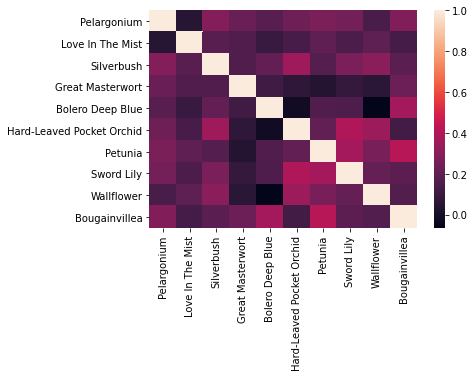

In [52]:
class_names_bert = []

for c in dataset_obj.classes:
    class_names_bert.append(transformer_model.encode(c))

matrix = cosine_similarity(np.array(class_names_bert))
print(matrix.mean())
sn.heatmap(matrix, xticklabels = dataset_obj.classes, yticklabels = dataset_obj.classes)

In [55]:
colors = ["white", "green", "blue", "purple", "pink", "red", "yellow", "orange", "brown", "grey", "black","violet","lavender", "golden", "tan"]

In [54]:
bert_emb_colors = {}

bert_embs = []
for c in dataset_obj.classes:
#     bert_embs.append(transformer_model.encode(f"This is a {c} flower."))
    bert_embs.append(transformer_model.encode(f"This is a {c} pet."))
    
color_bert_embs = []
for c in colors:
#     color_bert_embs.append(transformer_model.encode(f"This is a {c} color flower."))
    color_bert_embs.append(transformer_model.encode(f"This is a {c} color pet."))
    
cosine_scores = util.pytorch_cos_sim(bert_embs, color_bert_embs)
#Output the pairs with their score
for i in range(len(dataset_obj.classes)):
    bert_emb_colors[dataset_obj.classes[i]] = []
    for j in range(len(colors)):
        bert_emb_colors[dataset_obj.classes[i]].append((colors[j], cosine_scores[i][j]))

final_bert_emb_colors = {}
for key in bert_emb_colors:
    top3 = sorted(bert_emb_colors[key], key=lambda k: k[1])[-2:]
    final_bert_emb_colors[key] = [x[0] for x in top3]
    
final_bert_emb_colors

{'Pelargonium': ['pink', 'green'],
 'Love In The Mist': ['purple', 'pink'],
 'Silverbush': ['white', 'yellow'],
 'Great Masterwort': ['yellow', 'pink'],
 'Bolero Deep Blue': ['grey', 'blue'],
 'Hard-Leaved Pocket Orchid': ['green', 'purple'],
 'Petunia': ['blue', 'pink'],
 'Sword Lily': ['violet', 'purple'],
 'Wallflower': ['violet', 'lavender'],
 'Bougainvillea': ['blue', 'brown']}

In [37]:
# templates_f = ["This is a {} flower."]
# templates_c = ["This is a {} color flower."]

templates_f = ["This is a {} pet."]
templates_c = ["This is a {} color pet."]

clip_emb_colors = {}

colors_zw = zeroshot_classifier(colors,templates_f)
flowers_zw = zeroshot_classifier(dataset_obj.classes,templates_f)

cosine_scores = util.pytorch_cos_sim(colors_zw.T, flowers_zw.T)

#Output the pairs with their score
for i in range(len(dataset_obj.classes)):
    clip_emb_colors[dataset_obj.classes[i]] = []
    for j in range(len(colors)):
        clip_emb_colors[dataset_obj.classes[i]].append((colors[j], cosine_scores[j][i].cpu().numpy()))
        
final_clip_emb_colors = {}
for key in clip_emb_colors:
    top3 = sorted(clip_emb_colors[key], key=lambda k: k[1])[-2:]
    final_clip_emb_colors[key] = [x[0] for x in top3]
final_clip_emb_colors

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

{'Abyssinian': ['orange', 'brown'],
 'Bengal': ['white', 'brown'],
 'Birman': ['grey', 'white'],
 'Bombay Cat': ['grey', 'black'],
 'British Shorthair': ['white', 'grey'],
 'Egyptian Mau': ['white', 'grey'],
 'Maine Coon': ['black', 'green'],
 'Persian': ['grey', 'white'],
 'Ragdoll': ['grey', 'white'],
 'Russian Blue': ['blue', 'grey'],
 'Siamese': ['grey', 'white'],
 'Sphynx': ['pink', 'grey'],
 'American Bulldog': ['grey', 'white'],
 'American Pit Bull Terrier': ['brown', 'white'],
 'Basset Hound': ['white', 'brown'],
 'Beagle': ['brown', 'green'],
 'Boxer': ['red', 'brown'],
 'Chihuahua': ['grey', 'white'],
 'English Cocker Spaniel': ['brown', 'black'],
 'English Setter': ['grey', 'white'],
 'German Shorthaired': ['brown', 'grey'],
 'Great Pyrenees': ['grey', 'white'],
 'Havanese': ['black', 'white'],
 'Japanese Chin': ['black', 'white'],
 'Keeshond': ['white', 'grey'],
 'Leonberger': ['black', 'brown'],
 'Miniature Pinscher': ['brown', 'black'],
 'Newfoundland': ['white', 'black']

In [38]:
templates = ["a {} {} pet."]

def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = []
            for color in final_bert_emb_colors[classname]:
                texts.extend([
                    template.format(color, classname) for template in templates
                ])  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

colors_zw = zeroshot_classifier(dataset_obj.classes,templates)

colors_czs = clip_zero_shot(
    train_loader,
    dataset_obj.classes,
    colors_zw
)
print(colors_czs[0])

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

83.14301250679718


In [39]:
templates = ["a {} {} pet."]

def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = []
            for color in final_clip_emb_colors[classname]:
                texts.extend([
                    template.format(color, classname) for template in templates
                ])  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

colors_zw = zeroshot_classifier(dataset_obj.classes,templates)

colors_czs = clip_zero_shot(
    train_loader,
    dataset_obj.classes,
    colors_zw
)
print(colors_czs[0])

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

84.28493746601414


In [24]:
colors_manual = {
     'pelargonium': ["violet", "lavender"],
     'love in the mist': ["white", "blue", "purple"],
     'silverbush': ["white", "yellow"],
     'great masterwort': ["white", "pink", "magenta"],
     'bolero deep blue': ["purple", "lavender", "violet"],
     'hard-leaved pocket orchid': ["white", "pink", "lavender"],
     'petunia': ["white", "red", "pink"],
     'sword lily': ["red", "pink", "white"],
     'wallflower': ["red", "yellow", "orange"],
     'bougainvillea': ["purple", "violet", "pink", "white"],}

templates = ["a {} {} flower."]

def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = []
            for color in colors_manual[classname]:
                texts.extend([
                    template.format(color, classname) for template in templates
                ])  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

colors_zw = zeroshot_classifier(dataset_obj.classes,templates)

colors_czs = clip_zero_shot(
    train_loader,
    dataset_obj.classes,
    colors_zw
)
print(colors_czs[0])

  0%|          | 0/37 [00:00<?, ?it/s]

KeyError: 'Abyssinian'

In [40]:
from torch.nn.functional import softmax
from transformers import BertForNextSentencePrediction, BertTokenizer

# load pretrained model and a pretrained tokenizer
model = BertForNextSentencePrediction.from_pretrained('bert-base-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
def get_nsp(seq_A, seq_B):

    # encode the two sequences. Particularly, make clear that they must be 
    # encoded as "one" input to the model by using 'seq_B' as the 'text_pair'
    encoded = tokenizer.encode_plus(seq_A, text_pair=seq_B, return_tensors='pt')
#     print(encoded)
    # {'input_ids': tensor([[  101,   146,  1176, 18621,   106,   102,  2091,  1128,  1176,  1172, 136,   102]]),
    #  'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]]),
    #  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
    # NOTE how the token_type_ids are 0 for all tokens in seq_A and 1 for seq_B, 
    # this way the model knows which token belongs to which sequence

    # a model's output is a tuple, we only need the output tensor containing
    # the relationships which is the first item in the tuple
    seq_relationship_logits = model(**encoded)[0]

    # we still need softmax to convert the logits into probabilities
    # index 0: sequence B is a continuation of sequence A
    # index 1: sequence B is a random sequence
    probs = softmax(seq_relationship_logits, dim=1)

#     print(seq_relationship_logits)
    return probs[0].detach().cpu().numpy()[0]
    # tensor([[9.9993e-01, 6.7607e-05]], grad_fn=<SoftmaxBackward>)
    # very high value for index 0: high probability of seq_B being a continuation of seq_A
    
seq_A = 'What color is a Silverbush flower?'
seq_B = 'red.'

get_nsp(seq_A, seq_B)

0.9189596

In [45]:
nsp_colors = {}

for i in range(len(dataset_obj.classes)):
    nsp_colors[dataset_obj.classes[i]] = []
    for j in range(len(colors)):
        prob = get_nsp(f"What color is a {dataset_obj.classes[i]} pet?", f"{colors[j]}.")
        nsp_colors[dataset_obj.classes[i]].append((colors[j], prob))
        
final_nsp_colors = {}
for key in nsp_colors:
    top3 = sorted(nsp_colors[key], key=lambda k: k[1])[-2:]
    final_nsp_colors[key] = [x[0] for x in top3]
final_nsp_colors

{'Abyssinian': ['black', 'white'],
 'Bengal': ['white', 'lavender'],
 'Birman': ['blue', 'white'],
 'Bombay Cat': ['white', 'lavender'],
 'British Shorthair': ['pink', 'white'],
 'Egyptian Mau': ['black', 'white'],
 'Maine Coon': ['lavender', 'white'],
 'Persian': ['pink', 'lavender'],
 'Ragdoll': ['lavender', 'blue'],
 'Russian Blue': ['lavender', 'blue'],
 'Siamese': ['white', 'lavender'],
 'Sphynx': ['white', 'lavender'],
 'American Bulldog': ['black', 'white'],
 'American Pit Bull Terrier': ['black', 'white'],
 'Basset Hound': ['pink', 'white'],
 'Beagle': ['pink', 'white'],
 'Boxer': ['pink', 'white'],
 'Chihuahua': ['white', 'lavender'],
 'English Cocker Spaniel': ['lavender', 'white'],
 'English Setter': ['white', 'pink'],
 'German Shorthaired': ['lavender', 'white'],
 'Great Pyrenees': ['lavender', 'white'],
 'Havanese': ['violet', 'lavender'],
 'Japanese Chin': ['lavender', 'pink'],
 'Keeshond': ['white', 'pink'],
 'Leonberger': ['pink', 'lavender'],
 'Miniature Pinscher': ['p

In [46]:
templates = ["a {} pet."]

def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = []
            texts.extend([
                template.format(classname) for template in templates
            ])  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

colors_zw = zeroshot_classifier(dataset_obj.classes,templates)

colors_czs = clip_zero_shot(
    train_loader,
    dataset_obj.classes,
    colors_zw
)
print(colors_czs[0])

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

85.80750407830342


In [47]:
templates = ["a {} {} pet."]

def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = []
            for color in final_nsp_colors[classname]:
                texts.extend([
                    template.format(color, classname) for template in templates
                ])  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

colors_zw = zeroshot_classifier(dataset_obj.classes,templates)

colors_czs = clip_zero_shot(
    train_loader,
    dataset_obj.classes,
    colors_zw
)
print(colors_czs[0])

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

80.4241435562806


In [275]:
from transformers import BertTokenizer, BertForMaskedLM
from torch.nn import functional as F
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased',    return_dict = True)
text = "What color is a lotus? " + tokenizer.mask_token + " color."

input = tokenizer.encode_plus(text, return_tensors = "pt")
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)

output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
    word = tokenizer.decode([token])
    new_sentence = text.replace(tokenizer.mask_token, word)
    print(new_sentence)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


What color is a lotus? no color.
What color is a lotus? the color.
What color is a lotus? a color.
What color is a lotus? its color.
What color is a lotus? what color.
What color is a lotus? your color.
What color is a lotus? lotus color.
What color is a lotus? one color.
What color is a lotus? wrong color.
What color is a lotus? blue color.


In [57]:
from transformers import BertTokenizer, BertForMaskedLM
from torch.nn import functional as F
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased',    return_dict = True)
text = "A " + tokenizer.mask_token + " Abyssinian."

input = tokenizer.encode_plus(text, return_tensors = "pt")
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)

output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
    word = tokenizer.decode([token])
    new_sentence = text.replace(tokenizer.mask_token, word)
    print(new_sentence)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


A native Abyssinian.
A white Abyssinian.
A black Abyssinian.
A female Abyssinian.
A fellow Abyssinian.
A caucasian Abyssinian.
A young Abyssinian.
A southern Abyssinian.
A male Abyssinian.
A northern Abyssinian.
